In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
from scipy.stats import norm
figpath = '' #this path sends the figures to the directory that you want
savefigs = True
imgfrmt = 'pdf' #kind of format to save figures as

array([4.20138997, 4.80329501, 2.30610429])

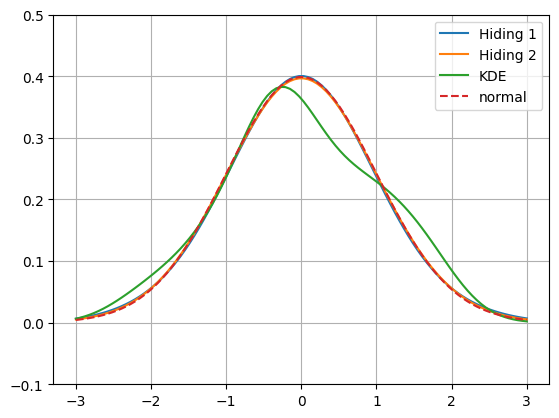

In [119]:
d = 1
n = 2**6

def conditionalDensity1(x, y2):
    return norm.pdf((x - y2) / 0.6) / 0.6

def conditionalDensity2(x, y1):
    return norm.pdf((x - y1) / 0.8) / 0.8

def condEstimator1(x, realizations):
    sum = 0
    n = len(realizations)
    for j in range(n):
        sum += conditionalDensity1(x, realizations[j])
    return sum / n

def condEstimator2(x, realizations):
    sum = 0
    n = len(realizations)
    for j in range(n):
        sum += conditionalDensity2(x, realizations[j])
    return sum / n

# averageAcross = 1
# def averagedCondEstimator1(x):
#     sum = 0.0
#     for i in range(averageAcross):
#         uniformPoints = qp.IIDStdUniform(d).gen_samples(n)
#         realizations2 = 0.8*norm.ppf(uniformPoints) + 0
#         sum += condEstimator1(x, realizations2) / averageAcross
#     return sum

# def averagedCondEstimator2(x):
#     sum = 0.0
#     for i in range(averageAcross):
#         uniformPoints = qp.IIDStdUniform(d).gen_samples(n)
#         realizations2 = 0.6*norm.ppf(uniformPoints) + 0
#         sum += condEstimator2(x, realizations2) / averageAcross
#     return sum

def kernelDensityEstimator(x, uniformPoints, bandwidth):
    n = len(uniformPoints)
    def gaussianKernel(z):
        return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    def thisFunc(z1, z2):
        return 0.6*norm.ppf(z1) + 0.8*norm.ppf(z2)
    for i in range(n):
        sum += (1 / (n * bandwidth)) * gaussianKernel((x - thisFunc(uniformPoints[i][0], uniformPoints[i][1])) / bandwidth)
    return sum
    
uniformPoints1d = qp.IIDStdUniform(d).gen_samples(n)
uniformPoints2d = qp.IIDStdUniform(2).gen_samples(n)
uniformRealization2 = 0.8*norm.ppf(uniformPoints1d) + 0
uniformRealization1 = 0.6*norm.ppf(uniformPoints1d) + 0

sobolPoints = qp.Sobol(d).gen_samples(n)
sobolRealization2 = 0.8*norm.ppf(sobolPoints) + 0
sobolRealization1 = 0.6*norm.ppf(sobolPoints) + 0


nEval = 100
evalPoints = np.linspace(-3, 3, nEval)
fig, ax = plt.subplots()


list1 = condEstimator1(evalPoints, sobolRealization2)
ax.plot(evalPoints, list1, label = 'Hiding 1')

list2 = condEstimator2(evalPoints, sobolRealization1)
ax.plot(evalPoints, list2, label = 'Hiding 2')


Q = 7.5671927
bandwidth = Q**(1/5) / n**(1/5)
list3 = kernelDensityEstimator(evalPoints, uniformPoints2d, bandwidth)
ax.plot(evalPoints, list3, label = 'KDE')

ax.plot(evalPoints, norm.pdf(evalPoints), '--', label = 'normal')
ax.set_ylim(-0.1, 0.5)
legend = ax.legend()

nMise = 100
misePoints = np.linspace(-3, 3, nMise)
estimatedMise1 = (6 / nMise) * np.sum((list1 - norm.pdf(misePoints))**2)
estimatedMise2 = (6 / nMise) * np.sum((list2 - norm.pdf(misePoints))**2)
estimatedMiseKDE = (6 / nMise) * np.sum((list3 - norm.pdf(misePoints))**2)
ax.grid(True)

-np.log10([estimatedMise1, estimatedMise2, estimatedMiseKDE])






In [38]:
def getError(pointSetType, n, method):
    nMise = 100
    misePoints = np.linspace(-3, 3, nMise)

    nEval = 100
    evalPoints = np.linspace(-3, 3, nEval)
    if n <= 0:
        raise Exception("Not valid choice of n")
    
    if method == "KDE":
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(2).gen_samples(n)
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(2).gen_samples(n)
        else:
            raise Exception("Not support pointSetType")
        # VERY HACKY JOB OF HANDLING VARIABLE BANDIWDTHS DO NOT OPEN DO NOT OPEN USING OPTIMAL USING FORMULA
        Q = 7.5671927
        bandwidth = Q**(1/5) / n**(1/5)
        evaluatedPoints = kernelDensityEstimator(misePoints, pointSet, bandwidth)
        estimatedMiseKDE = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
        return estimatedMiseKDE
    
    elif method == "hiding1" or method == "hiding2":
        if pointSetType == "MC":
            pointSet = qp.IIDStdUniform(1).gen_samples(n)
        elif pointSetType == "Sobol":
            pointSet = qp.Sobol(1).gen_samples(n)
        else:
            raise Exception("Not supported pointSetType")
        
        if method == "hiding1":
            realization2 = 0.8*norm.ppf(pointSet)
            evaluatedPoints = condEstimator1(misePoints, realization2)
            estimatedMise1 = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
            return estimatedMise1
        elif method == "hiding2":
            realization1 = 0.6*norm.ppf(pointSet)
            evaluatedPoints = condEstimator2(misePoints, realization1)
            estimatedMise2 = (6 / nMise) * np.sum((evaluatedPoints - norm.pdf(misePoints))**2)
            return estimatedMise2
    
    else:
        raise Exception("Not supported method")
    
    raise Exception("How did we get here?")
    
def getAveragedLog10Error(pointSetType, n, method, averageOver):
    if averageOver <= 0:
        raise Exception("Not valid averageOver")
    avg = 0
    for i in range(averageOver):
        avg += (1 / averageOver) * getError(pointSetType, n, method)
    return -np.log10(avg)

# for l in ["hiding1", "hiding2", "KDE"]:
#     for k in ["MC", "Sobol"]:
#         output = []
#         for j in range(10, 17, 2):
#             output.append(getAveragedLog10Error(k, 2**j, l, 8))
#         print(k, l, output)


for k in ["MC", "Sobol"]:
    output = []
    for j in range(10, 19, 2):
        output.append(getAveragedLog10Error(k, 2**j, "KDE", 8))
    print(k, output)


MC [3.114634154709124, 3.4018043765605905, 3.930169925509371, 4.524922466384792, 4.818957964131105]
Sobol [3.6000826798148706, 4.080124955536643, 4.563370496484485, 5.039726403843163, 5.519389579952182]
